In [1]:
from PIL import Image, ImageDraw
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
from PIL import Image, ExifTags

PADDING = 0
OUTPUT_SCALE = 1

def weighted_average(hist):
    total = sum(hist)
    value, error = 0, 0
    if total > 0:
        value = sum(i * x for i, x in enumerate(hist)) / total
        error = sum(x * (value - i) ** 2 for i, x in enumerate(hist)) / total
        error = error ** 0.5
    return value, error


def color_from_histogram(hist):
    r, re = weighted_average(hist[:256])
    g, ge = weighted_average(hist[256:512])
    b, be = weighted_average(hist[512:768])
    e = re * 0.2989 + ge * 0.5870 + be * 0.1140
    return (int(r), int(g), int(b)), e


class QuadtreeNode(object):

    def __init__(self, img, box, depth):
        self.box = box
        self.depth = depth
        self.children = None
        self.leaf = False

        image = img.crop(box)
        self.width, self.height = image.size
        hist = image.histogram()
        self.color, self.error = color_from_histogram(hist)

    def is_leaf(self):
        return self.leaf

    def split(self, img):
        l, t, r, b = self.box
        if r - l > 1 and b - t > 1:
            lr = l + (r - l) / 2
            tb = t + (b - t) / 2
            tl = QuadtreeNode(img, (l, t, lr, tb), self.depth+1)
            tr = QuadtreeNode(img, (lr, t, r, tb), self.depth+1)
            bl = QuadtreeNode(img, (l, tb, lr, b), self.depth+1)
            br = QuadtreeNode(img, (lr, tb, r, b), self.depth+1)
            self.children = [tl, tr, bl, br]


class Quadtree(object):
    def __init__(self, image, max_depth=1024):
        self.root = QuadtreeNode(image, image.getbbox(), 0)
        self.width, self.height = image.size
        self.max_depth = 0

        self._build_tree(image, self.root, max_depth)

    def _build_tree(self, image, node, max_depth):
        if (node.depth >= max_depth) or (node.width <= 1 and node.height <= 1):
            if node.depth > self.max_depth:
                self.max_depth = node.depth
            node.leaf = True
            return

        node.split(image)
        for child in node.children:
            self._build_tree(image, child, max_depth)

    def get_leaf_nodes(self, depth):
        def get_leaf_nodes_recusion(tree, node, depth, func):
            if node.leaf is True or node.depth == depth:
                func(node)
            elif node.children is not None:
                for child in node.children:
                    get_leaf_nodes_recusion(tree, child, depth, func)

        if depth > self.max_depth:
            raise ValueError('A depth larger than the trees depth was given')

        leaf_nodes = []
        get_leaf_nodes_recusion(self, self.root, depth, leaf_nodes.append)
        return leaf_nodes

    def _create_image_from_depth(self, depth):
        m = OUTPUT_SCALE
        dx, dy = (PADDING, PADDING)
        image = Image.new('RGB', (int(self.width * m + dx),
                                  int(self.height * m + dy)))
        draw = ImageDraw.Draw(image)
        draw.rectangle((0, 0, self.width * m + dx,
                        self.height * m + dy), (0, 0, 0))

        leaf_nodes = self.get_leaf_nodes(depth)
        for node in leaf_nodes:
            l, t, r, b = node.box
            box = (l * m + dx, t * m + dy, r * m - 1, b * m - 1)
            draw.rectangle(box, node.color)
        return image

    def render_at_depth(self, depth=0):
        fig, ax = plt.subplots()
        if depth > self.max_depth:
            raise ValueError('A depth larger than the trees depth was given')

        image = self._create_image_from_depth(depth)
        image.show()
        return fig

    def create_gif(self, file_name, duration=1000, loop=0):
        images = []
        end_product_image = self._create_image_from_depth(self.max_depth)
        for i in range(self.max_depth):
            image = self._create_image_from_depth(i)
            images.append(image)

        for _ in range(4):
            images.append(end_product_image)

        images[0].save(
            file_name,
            save_all=True,
            append_images=images[1:],
            duration=duration, loop=loop)
    
    def calculate_size(self):
        def calculate_size_recursion(node):
            size = 1 
            if node.children is not None:
                for child in node.children:
                    size += calculate_size_recursion(child)
            return size

        return calculate_size_recursion(self.root)

    def print_sizes_and_ratio(self):
        input_size = self.width * self.height * 3
        output_size = self.calculate_size() * 24
        compression_ratio = input_size / output_size

        print(f"Input image size: {input_size} bytes")
        print(f"Output image size: {output_size} bytes")
        print(f"Compression ratio: {compression_ratio}")

In [2]:
from PIL import Image, ImageFilter, ImageEnhance

def denoise_image(image):
    # Use Median filter for denoising
    return image.filter(ImageFilter.MedianFilter(size=3))

def enhance_edges(image):
    # Use FIND_EDGES filter for edge enhancement
    return image.filter(ImageFilter.FIND_EDGES)

def adjust_contrast(image):
    # Use ImageEnhance for contrast adjustment
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(2)  # Increase contrast

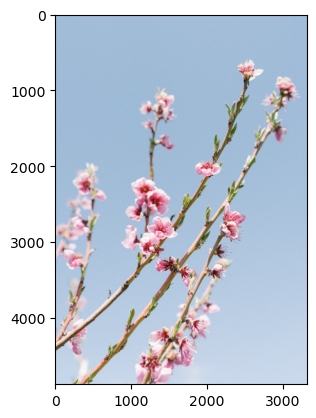

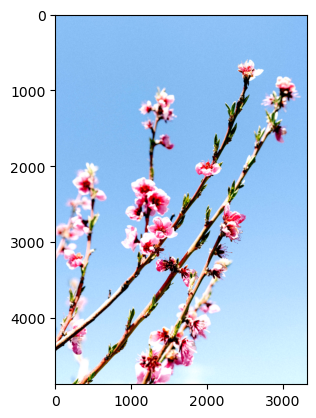

In [7]:
from PIL import Image, ExifTags, JpegImagePlugin

# Load the image
image = Image.open('/home/sai/Desktop/QTIC/QuadTree_ADSA/Images/flowers.jpg').convert('RGB')

# Extract EXIF data
exif_data = image._getexif() if hasattr(image, '_getexif') else JpegImagePlugin.JpegImageFile._getexif(image)
if exif_data is not None:
    for tag, value in exif_data.items():
        tag_name = ExifTags.TAGS.get(tag, tag)
        print(f"{tag_name}: {value}")

import matplotlib.pyplot as plt

image = denoise_image(image)
plt.imshow(image, cmap='gray')
plt.show()

image = enhance_edges(image)
plt.imshow(image, cmap='gray')
plt.show()

image = adjust_contrast(image)
plt.imshow(image, cmap='gray')
plt.show()

# Now you can compress the image
quadtree = Quadtree(image, max_depth=10)

In [8]:
fig = quadtree.render_at_depth(10)
fig.savefig('/home/sai/Desktop/QTIC/QuadTree_ADSA/CompressedImages')
plt.close(fig)


(cobalt:2): Gdk-WARNING **: 20:19:46.930: Failed to read portal settings: GDBus.Error:org.freedesktop.DBus.Error.UnknownMethod: No such interface “org.freedesktop.portal.Settings” on object at path /org/freedesktop/portal/desktop


Opening in existing browser session.


In [5]:
quadtree.max_depth
quadtree.print_sizes_and_ratio()
quadtree.create_gif('flowers.gif', duration=1000, loop=0)

Input image size: 48614148 bytes
Output image size: 33554424 bytes
Compression ratio: 1.4488148567235128



(cobalt:2): Gdk-WARNING **: 20:14:44.953: Failed to read portal settings: GDBus.Error:org.freedesktop.DBus.Error.UnknownMethod: No such interface “org.freedesktop.portal.Settings” on object at path /org/freedesktop/portal/desktop


Opening in existing browser session.
